In [3]:
import torch
import torch.nn as nn
import numpy as np

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt

In [4]:
matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams["hatch.color"] = "white"

# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'device'
print(f"Using {device}")

Using cuda


In [124]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_layer_ct=2, hidden_dim=64, output_dim=1, activation=nn.Tanh(), *args, **kwargs) -> None:
        super(MLP,self).__init__(*args, **kwargs)
        self.input_dim = input_dim
        self.input_layer = nn.Sequential(nn.Linear(input_dim,hidden_dim), activation)
        hidden_layers = []
        for _ in range(hidden_layer_ct):
            hidden_layers.append(nn.Linear(hidden_dim,hidden_dim))
            hidden_layers.append(activation)
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Sequential(nn.Linear(hidden_dim,output_dim))
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [134]:
class PINN_0D:
    def __init__(self, net=MLP()) -> None:
        self.net = net.to(device)
        self.t_bounds = [0,2]
        self.collocation_ct = 250
        self.dim = 1
        
        self.loss_fn = nn.MSELoss()
        self.adam = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )

        self.harmonic_osc_k = 8
        self.harmonic_osc_mu = 0.1

        self.runs = []
        self.loss_history = []
  
    def sample_ics(self):
        pts = torch.Tensor([
            [self.t_bounds[0]],
        ]).to(device).requires_grad_(True)

        u = torch.Tensor([
            [1],
        ]).to(device).requires_grad_(True)

        u_t = torch.Tensor([
            [0],
        ]).to(device).requires_grad_(True)

        return pts, u, u_t

    def sample_collocation(self):
        pts_norm = torch.rand((self.collocation_ct, self.dim), device=device).requires_grad_(True)
        pts = pts_norm * (self.t_bounds[1]- self.t_bounds[0]) + self.t_bounds[0]
        return pts 

    def train_step(self):
        self.adam.zero_grad()
        self.lbfgs.zero_grad()

        pts_ic, u_ic, u_t_ic = self.sample_ics()
        pts_col = self.sample_collocation()
        pts = torch.vstack([pts_ic, pts_col])
        u_pred = self.net(pts)
        u_ic_pred = u_pred[:pts_ic.shape[0]]
        u_col_pred = u_pred[pts_ic.shape[0]:]

        u_t_pred = torch.autograd.grad(
            inputs=pts,
            outputs= u_pred,
            grad_outputs=torch.ones_like(u_pred).to(device),
            create_graph=True
        )[0]

        u_t_ic_pred = u_t_pred[:pts_ic.shape[0]]
        u_t_col_pred = u_t_pred[pts_ic.shape[0]:]

        u_tt_pred = torch.autograd.grad(
            inputs=pts,
            outputs=u_t_pred,
            grad_outputs=torch.ones_like(u_t_pred).to(device),
            create_graph=True
        )[0]

        u_tt_ic_pred = u_tt_pred[:pts_ic.shape[0]]
        u_tt_col_pred = u_tt_pred[pts_ic.shape[0]:]

        loss_u_ic = self.loss_fn(u_ic_pred,u_ic)
        loss_u_t_ic = self.loss_fn(u_t_ic_pred,u_t_ic)

        # Harmonic Oscillator
        governing_eq = u_tt_col_pred + self.harmonic_osc_mu * u_t_col_pred + self.harmonic_osc_k * u_col_pred

        # loss physics
        loss_physics = torch.mean(governing_eq**2)
        known_pts = torch.linspace(*self.t_bounds,7).to(device).requires_grad_(True).reshape(-1,1)
        u_known_true = self.oscillator_true(known_pts)
        u_known_pred = self.net(known_pts)
        loss_known = self.loss_fn(u_known_pred, u_known_true)

        loss = loss_u_ic + loss_u_t_ic + 0.01*loss_physics + loss_known
        # loss = loss_known
        loss.backward()
        return loss
    
    def train(self, n_epochs=500, mode='Adam', reporting_frequency=500):
        results = {
            "loss": []
        }
        # plt.figure()
        for it in range(n_epochs):
            loss = self.adam.step(self.train_step) if mode == "Adam" else self.lbfgs.step(self.train_step)
            results["loss"].append(loss.item())
            self.loss_history.append(loss.item())
            if (it) % reporting_frequency == 0:
                print(loss)
                # plt.cla()
                # plt.plot(self.loss_history)
                # plt.title(f"Loss {it}")
                # plt.show()
            if it ==n_epochs-1:
                print(loss)
        
        self.runs.append(results)

    def oscillator_true(self, t):
        """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
        d = self.harmonic_osc_mu/2
        w0 = np.sqrt(self.harmonic_osc_k)
        assert d < w0
        w = np.sqrt(w0**2-d**2)
        phi = np.arctan(-d/w)
        A = 1/(2*np.cos(phi))
        cos = torch.cos(phi+w*t)
        sin = torch.sin(phi+w*t)
        exp = torch.exp(-d*t)
        y  = exp*2*A*cos
        return y

        

        

In [135]:
pinn = PINN_0D()


In [136]:
pinn.harmonic_osc_k = 100
pinn.train(n_epochs=20, reporting_frequency=10, mode="Adam")
pinn.train(n_epochs=1000, reporting_frequency=100, mode="lb")

tensor(2.2286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4863, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4806, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3679, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3704, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3899, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3412, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

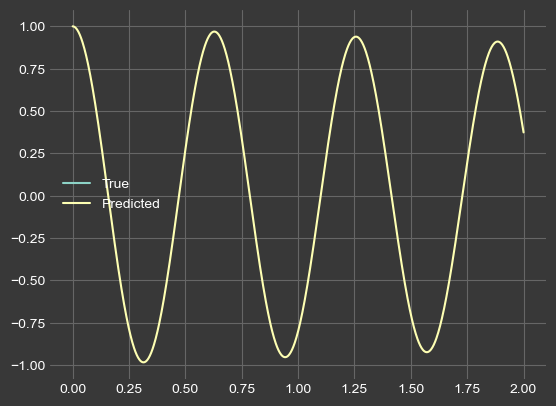

In [140]:
with torch.no_grad():
    t = torch.linspace(0,2,1000,device=device).reshape(-1,1)
    y = pinn.net(t)
    ytrue = pinn.oscillator_true(t)
    plt.figure()
    plt.plot(t.flatten().cpu(),y.flatten().cpu(), label="True")
    plt.plot(t.flatten().cpu(),ytrue.flatten().cpu(), label="Predicted")
    plt.legend()